Computing RNE embedding


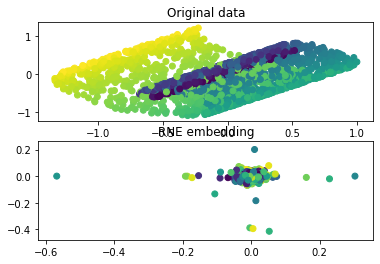

In [25]:
# -*- coding: utf-8 -*-


################################################################################
# RNE function

from scipy.sparse import linalg, eye
from pyamg import smoothed_aggregation_solver
from sklearn import neighbors
from sklearn.neighbors import kneighbors_graph
import numpy as np

def robust_neighbor_embedding(X, n_neighbors, out_dim, tol=1e-6, max_iter=200):
    
    #recevied from LLE
    W = neighbors.kneighbors_graph(
        X, n_neighbors=n_neighbors, mode='distance')
    #"connectivity" or "distance"
    #n,d = X.shape
    X = np.random.rand(W.shape[0], out_dim)
    n,d = X.shape
    H = np.random.rand(d, n)
    ## W
    
    # M = (I-W)' (I-W)
    #A = eye(*W.shape, format=W.format) - W
    #A = (A.T).dot(A).tocsr()
    A = ((eye(n) - np.transpose(W)) * X)#.tocsr()
    AA = np.dot(A.T,A) #.tocsr()
    AAplus = 0.5 * (np.abs(AA) + AA)
    AAsubtract = 0.5 * (np.abs(AA) - AA)
    
    #initialize H, Y, alpha, gamma, gamma_max, mu
    M = np.dot(A, H)
    Y = np.zeros((n,2000))
    mu = 1.1
    gamma = 10
    max_gamma = 10000000000.0
    alpha = 1000.0
##iter_num = 50
#iter_numH = 30


    AM = np.dot(np.transpose(A), M)
    AY =np.dot(np.transpose(A) , Y)
    AMplus = 0.5 * (np.abs(AM) + AM)
    AMsubtract = 0.5 * (np.abs(AM) - AM)
    AYplus = 0.5 * (np.abs(AY) + AY)
    AYsubtract = 0.5 * (np.abs(AY) - AY)
    iter_num = 50
    iter_numH = 30

    G1 = np.diag(np.sqrt(1.0 / np.diag(np.dot(np.transpose(H), H)) + 1))
    H = np.dot(H, G1)
    H = np.multiply(H,np.sqrt((alpha * H) + (gamma * AMplus)+np.dot(gamma*AAsubtract, H) + AYplus/ np.dot((alpha * H ), np.dot(np.transpose(H), H))+gamma * AMsubtract + gamma * np.dot(AAplus,H)+ AYsubtract + 1))
    H



    # compute eigenvalues and eigenvectors 
    eigen_values, eigen_vectors = np.linalg.eigh(np.dot(np.transpose(H), H))

    index = np.argsort(eigen_values)

    return eigen_vectors[:, index], np.sum(eigen_values)


import pylab as pl

################################################################################
# generate the swiss roll

n_samples, n_features = 2000, 3
n_turns, radius = 1.2, 1.0
rng = np.random.RandomState(0)
t = rng.uniform(low=0, high=1, size=n_samples)
data = np.zeros((n_samples, n_features))

# generate the 2D spiral data driven by a 1d parameter t
max_rot = n_turns * 2 * np.pi
data[:, 0] = radius = t * np.cos(t * max_rot)
data[:, 1] = radius = t * np.sin(t * max_rot)
data[:, 2] = rng.uniform(-1, 1.0, n_samples)
manifold = np.vstack((t * 2 - 1, data[:, 2])).T.copy()
colors = manifold[:, 0]

# rotate and plot original data
sp = pl.subplot(211)
U = np.dot(data, [[-.79, -.59, -.13],
                  [ .29, -.57,  .75],
                  [-.53,  .56,  .63]])
sp.scatter(U[:, 1], U[:, 2], c=colors)
sp.set_title("Original data")


print ("Computing RNE embedding")
n_neighbors, out_dim = 12, 2
X_r, cost = robust_neighbor_embedding(data, n_neighbors, out_dim)

sp = pl.subplot(212)
sp.scatter(X_r[:,0], X_r[:,1], c=colors)
sp.set_title("RNE embedding")
pl.show()

Computing RNE embedding
Done. Reconstruction error: 5.27198e+10


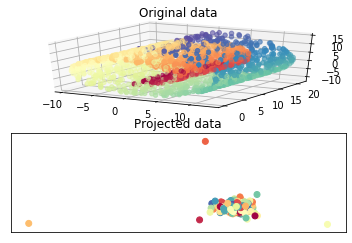

In [23]:
import pylab as pl
# This import is needed to modify the way figure behaves
from mpl_toolkits.mplot3d import Axes3D

#----------------------------------------------------------------------
# RNE of the swiss roll

from sklearn import manifold, datasets
X, color = datasets.make_swiss_roll(n_samples=2000)

print ("Computing RNE embedding")
n_neighbors, out_dim = 12, 6
X_r, err = robust_neighbor_embedding(X, n_neighbors, out_dim)
print ("Done. Reconstruction error: %g" % err)

#----------------------------------------------------------------------
# Plot result

fig = pl.figure()
try:
    # compatibility matplotlib < 1.0
    ax = fig.add_subplot(211, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=pl.cm.Spectral)
except:
    ax = fig.add_subplot(211)
    ax.scatter(X[:, 0], X[:, 2], c=color, cmap=pl.cm.Spectral)

ax.set_title("Original data")
ax = fig.add_subplot(212)
ax.scatter(X_r[:, 0], X_r[:, 1], c=color, cmap=pl.cm.Spectral)
pl.axis('tight')
pl.xticks([]), pl.yticks([])
pl.title('Projected data')
pl.show()